# Analysis on Diabetic Patients’ Hospital Admission & Classification of Readmission

A CSCI 271 Data Mining Project (Oct. 2020) by:

- AQUINO, Alec
- ARROBIO, Anne
- VILLAREAL, Rosiel

# Dataset
10 years of clinical care at 130 US hospitals including over 50 features representing patient and hospital outcomes of inpatients 
1. diagnosed with diabetes, 
2. admitted from 1-14 days, 
3. received medications

## Example features
- patient number
- age
- gender
- race
- admission type
- discharge disposition
- time in hospital
- medical specialty of admitting physician
- HbA1c test result
- Glucose serum test result
- number of lab tests performed
- diagnoses
- number of medications
- diabetic medications
- number of visits in the year before hospitalization

## Goal
Predict hospital readmission (Not readmitted, Readmitted within 30 days, Readmitted in more than 30 days) of patients using the given features.

# Pre-processing
1. Add columns to map IDs
        - admission type, admission source, discharge disposition
2. Drop irrelevant encounters & features
        - other encounters of the same patient
        - encounters that resulted in discharge due to hospice or patient death
            > discharge_disposition_id
            > expired = 11, 19, 20
            > hospice = 13, 14
            > total = 1,545 encounters
        - columns that contain too many null values
        - columns without relevant information
3. Replace diagnoses with category names
        - remove original diagnosis features

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#Load csv files from github 
df = pd.read_csv("https://raw.githubusercontent.com/bluerose98/diabetic_data/main/diabetic_data.csv")
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [3]:
# Check dataset dimensions
print(df.shape)

# Check columns
print(df.columns)

(101766, 50)
Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')


## 1. Add columns to map IDs
        - admission type, admission source, discharge disposition

In [4]:
# Add columns to map IDs
#Load csv files from github 
ad_type = pd.read_csv('https://raw.githubusercontent.com/bluerose98/diabetic_data/main/admission_type.csv')
ad_source = pd.read_csv('https://raw.githubusercontent.com/bluerose98/diabetic_data/main/admission_source.csv')
discharge = pd.read_csv('https://raw.githubusercontent.com/bluerose98/diabetic_data/main/discharge.csv')

df['admission_type'] = df['admission_type_id'].map(ad_type['description'])
df['admission_source'] = df['admission_source_id'].map(ad_source['description'])
df['discharge_disp'] = df['discharge_disposition_id'].map(discharge['description'])

In [5]:
# Check data types of columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

## 2. Drop irrelevant encounters & features
        - other encounters of the same patient
        - encounters that resulted in discharge due to hospice or patient death
            > discharge_disposition_id
            > expired = 11, 19, 20
            > hospice = 13, 14
            > total = 1,545 encounters
        - columns that contain too many null values
        - columns without relevant information

In [6]:
# Drop duplicate patient_nbr
unique_patients = df.drop_duplicates(subset=['patient_nbr'], keep='first')
unique_patients.shape

(71518, 53)

In [7]:
# Drop encounters that resulted in discharge due to hospice or patient death
hospice_death = [11, 19, 20, 13, 14]
df = unique_patients[~unique_patients['discharge_disposition_id'].isin(hospice_death)]
df.shape

(69973, 53)

In [8]:
df.drop(columns=['admission_type_id', 'admission_source_id', 'discharge_disposition_id'], inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [9]:
# Check for any null values
# Null values are represented by ? so replace ? with NaN
df = df.replace('?', np.nan)
df.isnull().sum()
# Here we can see some very problematic columns that have too much missing information

encounter_id                    0
patient_nbr                     0
race                         1918
gender                          0
age                             0
weight                      67185
time_in_hospital                0
payer_code                  30415
medical_specialty           33639
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                         10
diag_2                        293
diag_3                       1224
number_diagnoses                0
max_glu_serum                   0
A1Cresult                       0
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide                   0
glipizide                       0
glyburide                       0
tolbutamide   

In [10]:
# Drop columns that are missing too much data
df = df.drop(['weight', 'payer_code', 'medical_specialty'], axis=1)

# Remove null values
df = df.dropna()
df.isnull().sum()

encounter_id                0
patient_nbr                 0
race                        0
gender                      0
age                         0
time_in_hospital            0
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
diag_1                      0
diag_2                      0
diag_3                      0
number_diagnoses            0
max_glu_serum               0
A1Cresult                   0
metformin                   0
repaglinide                 0
nateglinide                 0
chlorpropamide              0
glimepiride                 0
acetohexamide               0
glipizide                   0
glyburide                   0
tolbutamide                 0
pioglitazone                0
rosiglitazone               0
acarbose                    0
miglitol                    0
troglitazone                0
tolazamide                  0
examide   

In [11]:
print(df.shape)
print('% data retained out of unique patients: ' + str(round(len(df.index)/71518 * 100,2)) + '%')
print('% data retained out of all encounters: ' + str(round(len(df.index)/101766 * 100,2)) + '%')
print(df.columns)

(63583, 47)
% data retained out of unique patients: 88.9%
% data retained out of all encounters: 62.48%
Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age',
       'time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses',
       'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
       'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'admission_type', 'admission_source', 'discharge_disp'],
      dtype='object')


In [12]:
# Drop other columns without relevant information
df = df.drop(['encounter_id', 'patient_nbr'], axis=1)
df.columns

Index(['race', 'gender', 'age', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'admission_type', 'admission_source', 'discharge_disp'],
      dtype='object')

## 3. Replace diagnoses with category names
        - remove original diagnosis features

In [13]:
# Replace diagnoses with category names
#Circulatory: 390-459, 785
#Respiratory: 460-519, 786
#Digestive: 520-579, 787
#Diabetes: 250.xx
#Injury: 800-999
#Musculoskeletal: 710-739
#Genitourinary: 580-629, 788
#Neoplasms: 140-239, 
#Other: 
#780, 781, 784, 790-799, 240-279 except 250, 680-709, 782, 001-139, 290-319
#E-V (beginning with a letter), 280-289, 320-359, 630-679, 360-389, 740-759

def categorize_diagnosis(diag):
    if diag.isnumeric():
        diag = int(diag)
        if diag in range(390,460) or diag==785:
            return 'Circulatory'
        elif diag in range(460,520) or diag==786:
            return 'Respiratory'
        elif diag in range(520,580) or diag==787:
            return 'Digestive'
        elif diag in np.arange(250,260,0.01):
            return 'Diabetes'
        elif diag in range(800,1000):
            return 'Injury'
        elif diag in range(710,740):
            return  'Musculoskeletal'
        elif diag in range(580,630) or diag==788:
            return  'Genitourinary'
        elif diag in range(140,240):
            return  'Neoplasms'
        else:
            return 'Other'
    else:
        if "250" in diag:
            return 'Diabetes'
        else:
            return  'Other'

In [14]:
df['diag_1_desc'] = df.apply(lambda row: categorize_diagnosis(row['diag_1']), axis=1)
df['diag_2_desc'] = df.apply(lambda row: categorize_diagnosis(row['diag_2']), axis=1)
df['diag_3_desc'] = df.apply(lambda row: categorize_diagnosis(row['diag_3']), axis=1)

# Remove original diagnosis features
df.drop(columns=['diag_1', 'diag_2', 'diag_3'], inplace=True)
df.columns

Index(['race', 'gender', 'age', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'number_diagnoses',
       'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
       'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'admission_type', 'admission_source', 'discharge_disp', 'diag_1_desc',
       'diag_2_desc', 'diag_3_desc'],
      dtype='object')

# EDA
    List initial insights / important points

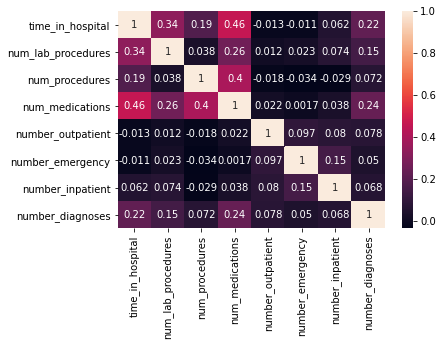

In [15]:
# corr matrix
corrMatrix = df.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [16]:
# List categorical and numeric features
categorical_feat = []
numerical_feat = []

for col in df.columns:
    if df[col].dtype == 'object':
        categorical_feat.append(col)
    elif 'id' in col:
        categorical_feat.append(col)
    elif df[col].dtype == 'int64':
        numerical_feat.append(col)

In [17]:
df.describe()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,63583.000000,63583.000000,63583.000000,63583.000000,63583.000000,63583.000000,63583.000000,63583.000000
mean,4.329082,43.653429,1.460579,15.776025,0.256326,0.103896,0.186481,7.336883
std,2.953868,19.734564,1.778664,8.340497,1.012119,0.519108,0.617623,1.892041
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,3.000000
25%,2.000000,32.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,4.000000,45.000000,1.000000,14.000000,0.000000,0.000000,0.000000,8.000000
75%,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,0.000000,9.000000
max,14.000000,132.000000,6.000000,81.000000,42.000000,42.000000,12.000000,16.000000


In [18]:
# for numeric variables with 0 values
num_col_z = ['num_procedures','number_outpatient','number_emergency','number_inpatient']

for i in num_col_z:
    print(i + ': ' + str(df[df[i]==0].shape))
    n = df[i].replace(0, np.NaN)
    print(n.describe())
    print('\n')

num_procedures: (27586, 45)
count    35997.000000
mean         2.579882
std          1.643289
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          6.000000
Name: num_procedures, dtype: float64


number_outpatient: (55950, 45)
count    7633.000000
mean        2.135202
std         2.126455
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max        42.000000
Name: number_outpatient, dtype: float64


number_emergency: (58965, 45)
count    4618.000000
mean        1.430489
std         1.346442
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        42.000000
Name: number_emergency, dtype: float64


number_inpatient: (55730, 45)
count    7853.000000
mean        1.509869
std         1.044263
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        12.000000
Name: number_inpatient, dtype: float64




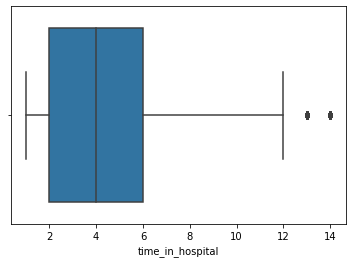

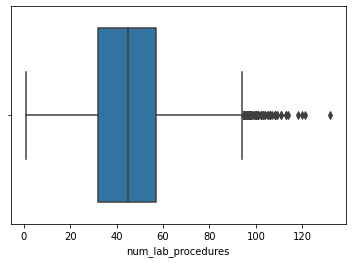

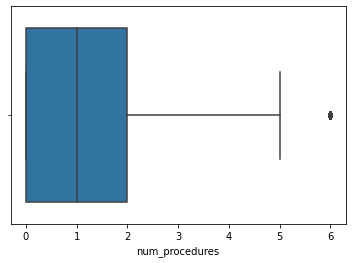

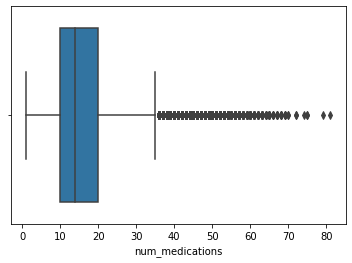

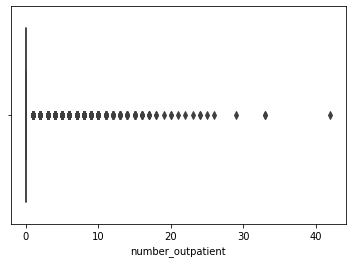

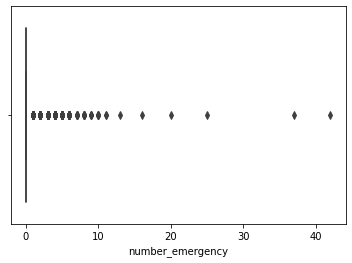

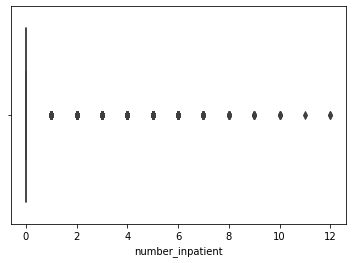

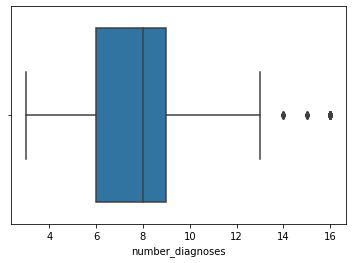

In [19]:
# Boxplot - numeric features
for i in numerical_feat:
    plt.figure(i)
    sns.boxplot(x=df[i])

In [20]:
# Patient count by age and gender
age_gender = df.groupby(['age','gender']).count()
age_gender.iloc[:,0]
# most no. of patients are females aged 70-79 y/o >> males of same age group

age       gender         
[0-10)    Female               34
          Male                 29
[10-20)   Female              201
          Male                132
[20-30)   Female              612
          Male                342
[30-40)   Female             1390
          Male                985
[40-50)   Female             2995
          Male               3128
[50-60)   Female             5507
          Male               5812
[60-70)   Female             7085
          Male               7405
[70-80)   Female             8728
          Male               7517
          Unknown/Invalid       1
[80-90)   Female             6197
          Male               3899
[90-100)  Female             1135
          Male                449
Name: race, dtype: int64

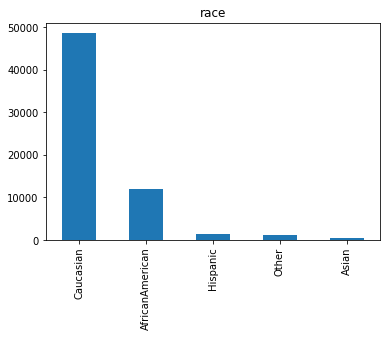

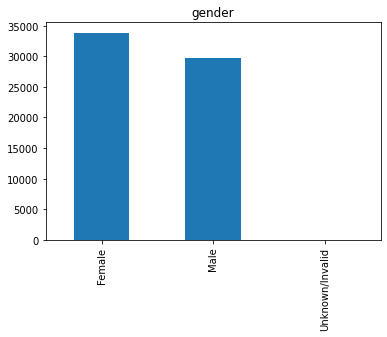

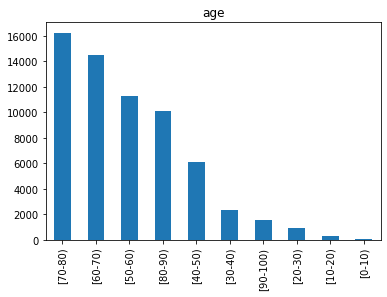

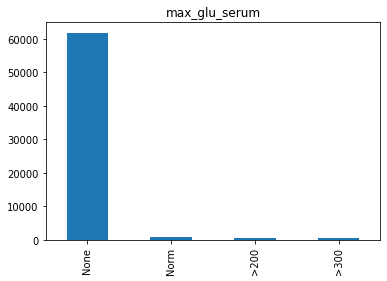

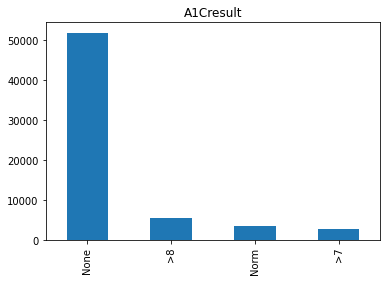

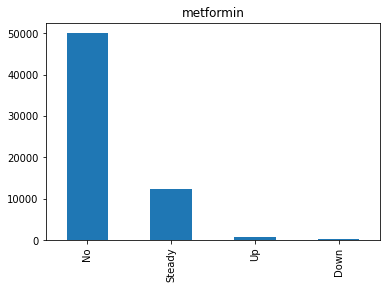

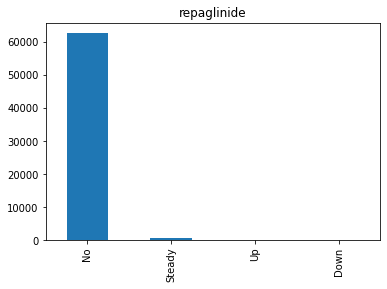

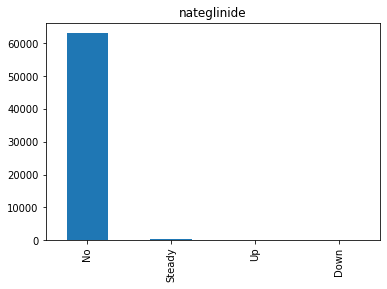

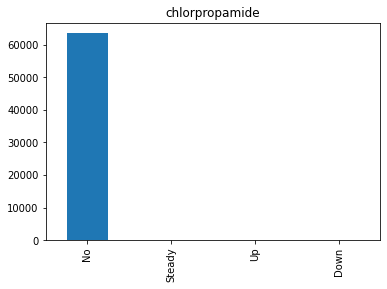

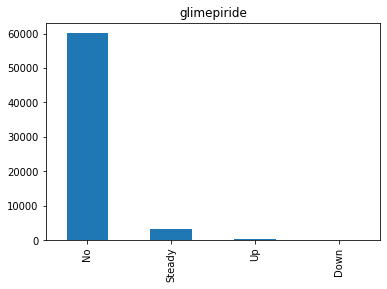

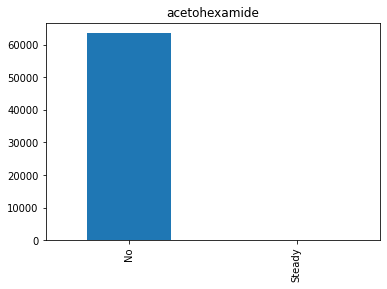

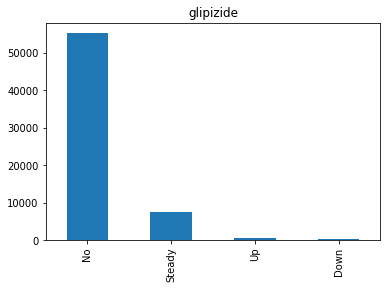

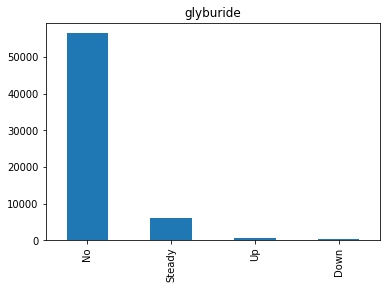

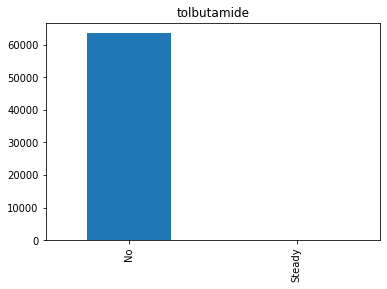

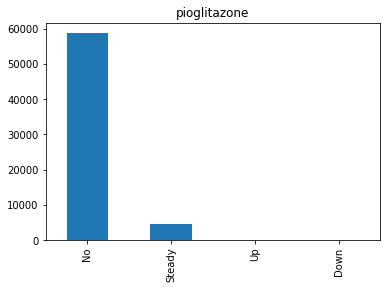

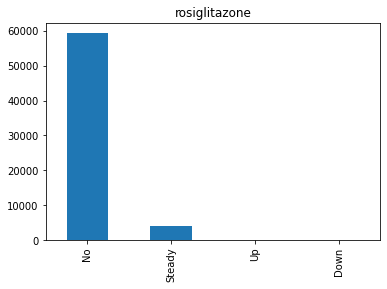

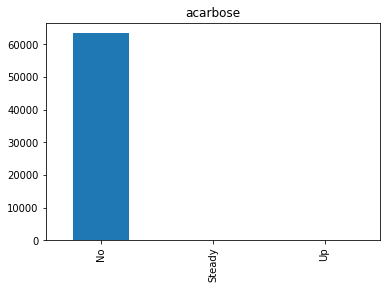

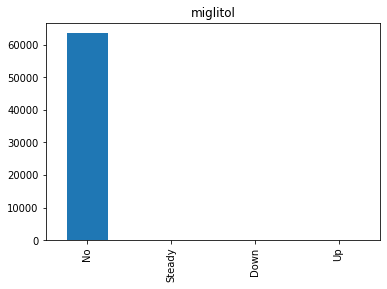

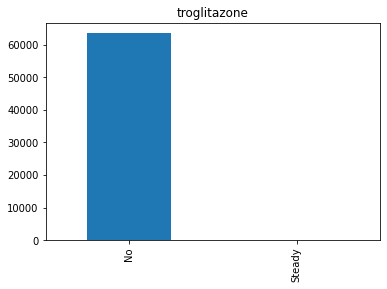

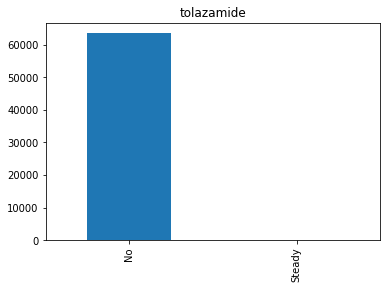

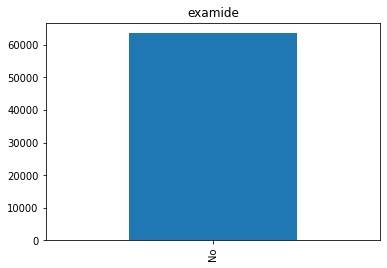

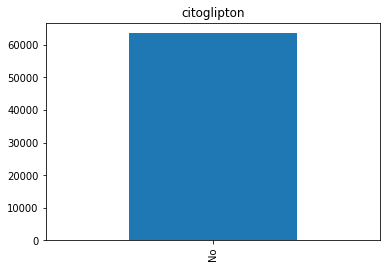

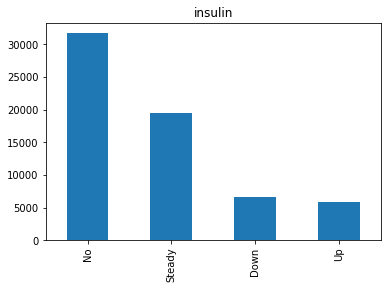

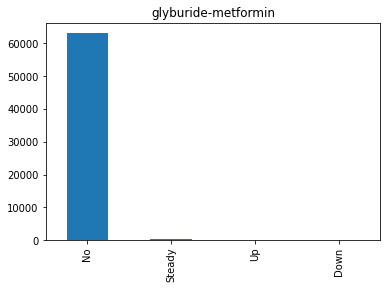

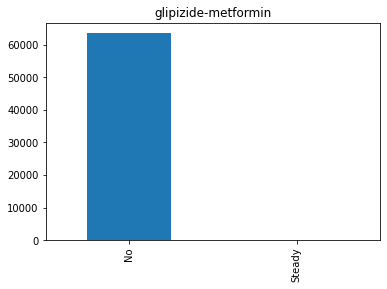

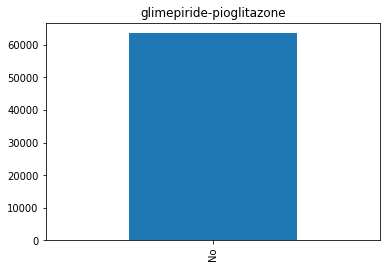

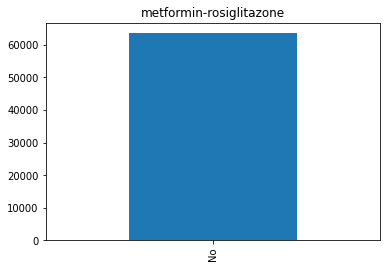

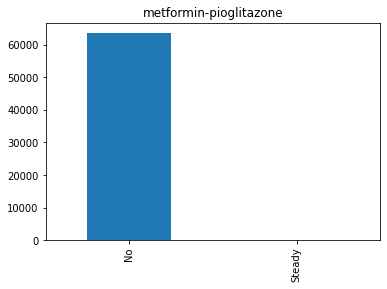

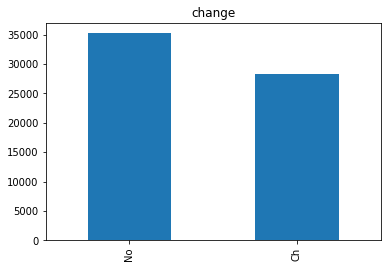

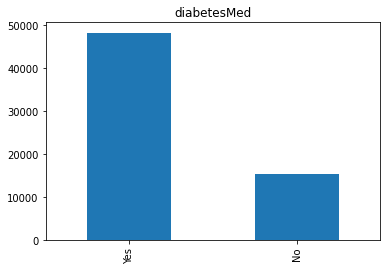

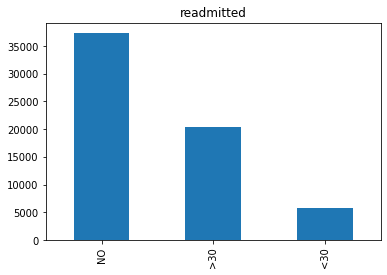

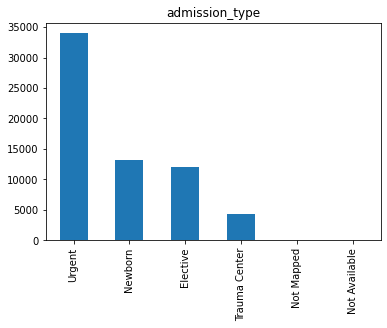

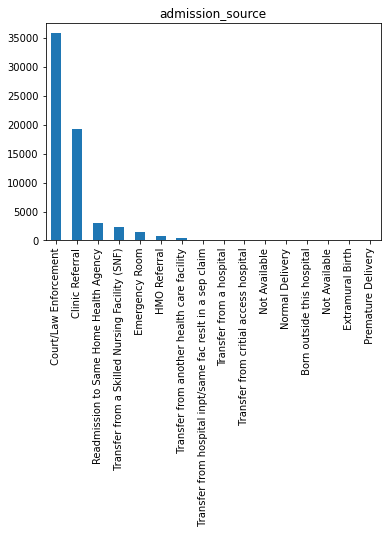

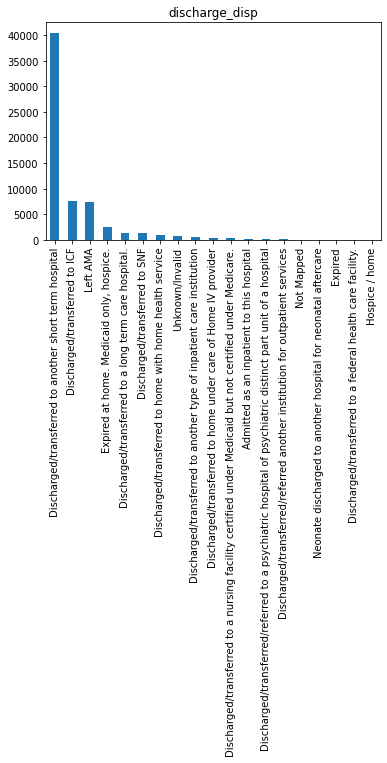

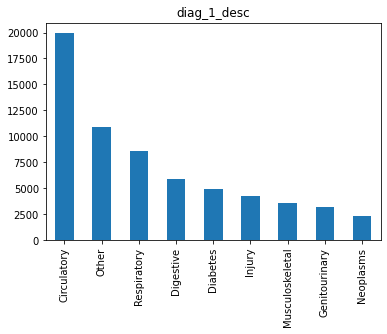

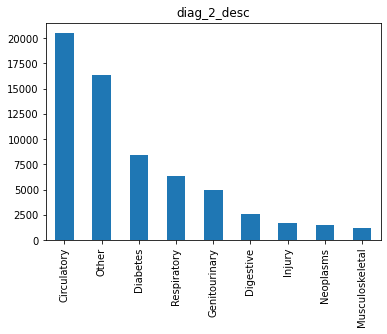

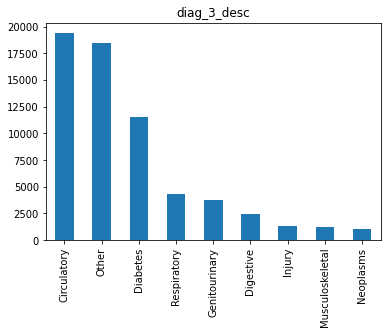

In [21]:
# Bar - categorical
for i in categorical_feat:
    plt.rcParams.update({'figure.max_open_warning': 0})
    plt.figure(i)
    plt.title(i)
    df[i].value_counts().plot(kind='bar')

# A1C: 83% not tested
# Glucose serum: 95% not testes
# big % not tested but almost 50% changed meds; what diagnoses?
# big % not tested but 77% are prescribed diabetes medications

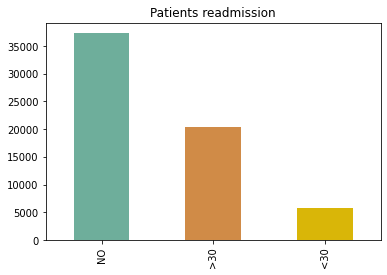

In [22]:
plt.figure()
plt.title('Patients readmission')
df['readmitted'].value_counts().plot(kind='bar',color=['#6EAE9B','#D08B47','#D9B608'])

In [23]:
# % of categ features
for i in categorical_feat:
    a = df.groupby([i]).size().reset_index(name='counts')
    a['pcts'] = round((a['counts']/a['counts'].sum() * 100),2)
    print(a)

              race  counts   pcts
0  AfricanAmerican   12043  18.94
1            Asian     465   0.73
2        Caucasian   48600  76.44
3         Hispanic    1381   2.17
4            Other    1094   1.72
            gender  counts   pcts
0           Female   33884  53.29
1             Male   29698  46.71
2  Unknown/Invalid       1   0.00
        age  counts   pcts
0    [0-10)      63   0.10
1   [10-20)     333   0.52
2   [20-30)     954   1.50
3   [30-40)    2375   3.74
4   [40-50)    6123   9.63
5   [50-60)   11319  17.80
6   [60-70)   14490  22.79
7   [70-80)   16246  25.55
8   [80-90)   10096  15.88
9  [90-100)    1584   2.49
  max_glu_serum  counts   pcts
0          >200     451   0.71
1          >300     393   0.62
2          None   61915  97.38
3          Norm     824   1.30
  A1Cresult  counts   pcts
0        >7    2654   4.17
1        >8    5520   8.68
2      None   51875  81.59
3      Norm    3534   5.56
  metformin  counts   pcts
0      Down     395   0.62
1        No   50013

In [24]:
# Get counts for each readmitted, diagnosis 1 desc
df_diag_cnt = df.groupby(['readmitted', 'diag_1_desc']).size().reset_index(name='counts')
df_diag_cnt = df_diag_cnt[df_diag_cnt['readmitted']=='<30']
df_diag_cnt1 = df_diag_cnt['counts'].tolist()

df_diag_cnt = df.groupby(['readmitted', 'diag_1_desc']).size().reset_index(name='counts')
df_diag_cnt = df_diag_cnt[df_diag_cnt['readmitted']=='>30']
df_diag_cnt2 = df_diag_cnt['counts'].tolist()

df_diag_cnt = df.groupby(['readmitted', 'diag_1_desc']).size().reset_index(name='counts')
df_diag_cnt = df_diag_cnt[df_diag_cnt['readmitted']=='NO']
df_diag_cnt3 = df_diag_cnt['counts'].tolist()
#df_diag_cnt

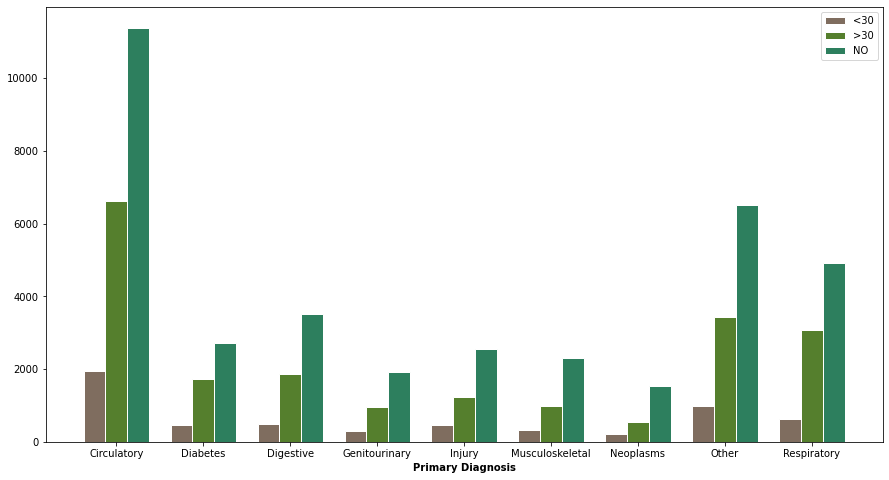

In [25]:
# Plot Readmission vs Primary Diagnosis
df1 = df[['diag_1_desc','readmitted']]
df1

fig,ax = plt.subplots()
fig.set_size_inches(15, 8)

# set width of bar
barWidth = 0.25
 
# set height of bar
bars1 = df_diag_cnt1
bars2 = df_diag_cnt2
bars3 = df_diag_cnt3
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# Make the plot
plt.bar(r1, bars1, color='#7f6d5f', width=barWidth, edgecolor='white', label='<30')
plt.bar(r2, bars2, color='#557f2d', width=barWidth, edgecolor='white', label='>30')
plt.bar(r3, bars3, color='#2d7f5e', width=barWidth, edgecolor='white', label='NO')
 
# Add xticks on the middle of the group bars
plt.xlabel('Primary Diagnosis', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['Circulatory', 'Diabetes', 'Digestive', 'Genitourinary', 'Injury',
                                                      'Musculoskeletal','Neoplasms','Other','Respiratory'])
 
# Create legend & Show graphic
plt.legend()
plt.show()

In [26]:
# Number of patients per readmitted ind and primary diagnosis
df_diag_cnt = df.groupby(['readmitted', 'diag_1_desc']).size().reset_index(name='counts')
df_diag_cnt

,readmitted,diag_1_desc,counts
0,<30,Circulatory,1942
1,<30,Diabetes,469
2,<30,Digestive,482
3,<30,Genitourinary,286
4,<30,Injury,464
5,<30,Musculoskeletal,316
6,<30,Neoplasms,214
7,<30,Other,988
8,<30,Respiratory,634
9,>30,Circulatory,6619


In [27]:
# A1C Results vs Readmitted
df.groupby(['A1Cresult','readmitted']).size().reset_index(name='counts')

,A1Cresult,readmitted,counts
0,>7,<30,226
1,>7,>30,801
2,>7,NO,1627
3,>8,<30,469
4,>8,>30,1785
5,>8,NO,3266
6,None,<30,4791
7,None,>30,16873
8,None,NO,30211
9,Norm,<30,309


In [28]:
total_a1c_res = df.groupby(['A1Cresult']).size().reset_index(name='counts')
a1c_res_readm_cnt = df.groupby(['readmitted', 'A1Cresult']).size().reset_index(name='counts')

read_a1c = a1c_res_readm_cnt.groupby(['readmitted', 'A1Cresult']).agg({'counts': 'sum'})
read = a1c_res_readm_cnt.groupby(['A1Cresult']).agg({'counts': 'sum'})
a1c_pcts = read_a1c.div(read) * 100
a1c_pcts.rename(columns = {'counts':'pcts'})

pcts
readmitted A1Cresult           
<30        >7          8.515448
           >8          8.496377
           None        9.235663
           Norm        8.743633
>30        >7         30.180859
           >8         32.336957
           None       32.526265
           Norm       27.843803
NO         >7         61.303693
           >8         59.166667
           None       58.238072
           Norm       63.412564

In [29]:
# means
df.groupby(['readmitted']).mean()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
readmitted,,,,,,,,
<30,4.855393,45.655910,1.460569,16.735289,0.285418,0.148749,0.385850,7.588956
>30,4.465734,44.617718,1.392653,15.946534,0.350242,0.150369,0.269677,7.562148
NO,4.172607,42.814835,1.497764,15.533833,0.200402,0.071496,0.110001,7.174454


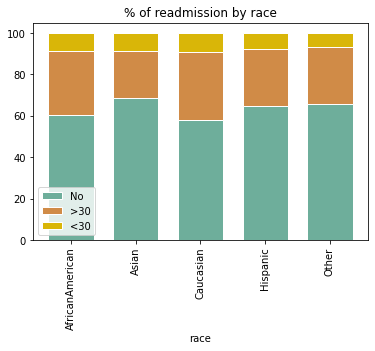

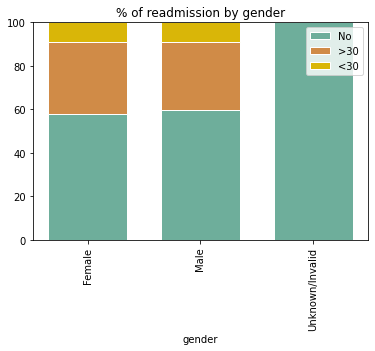

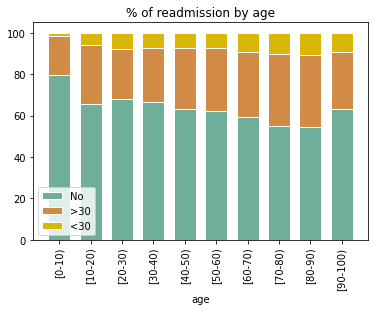

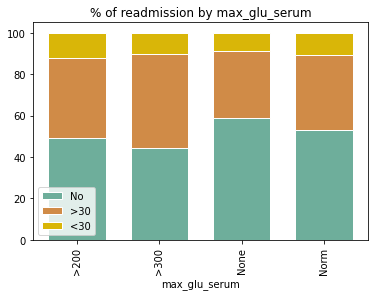

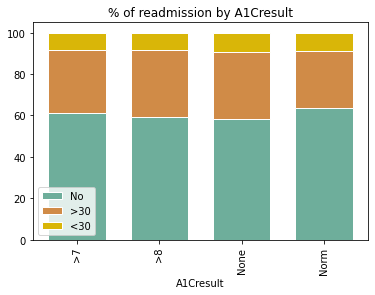

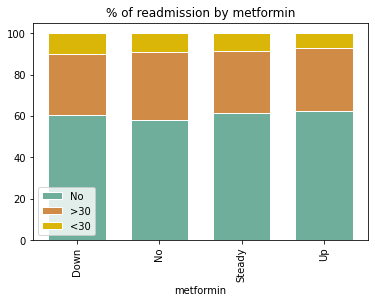

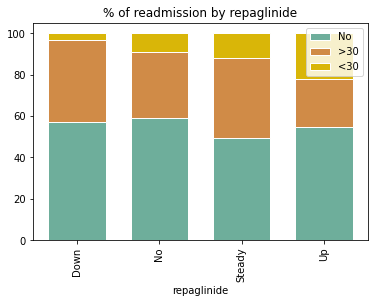

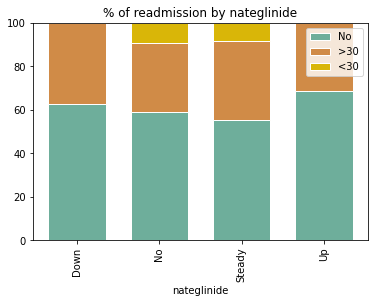

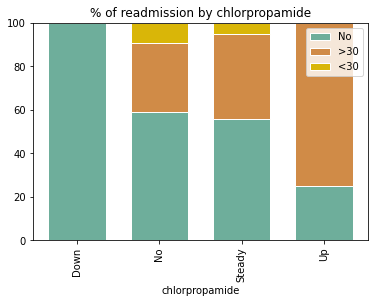

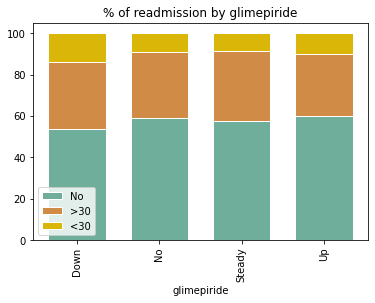

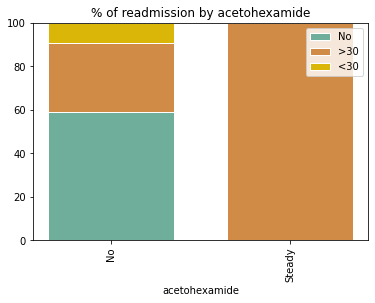

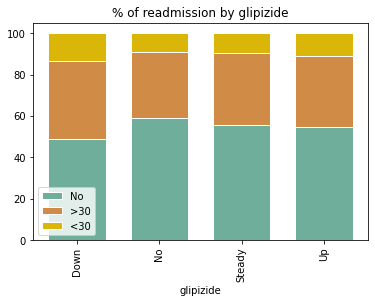

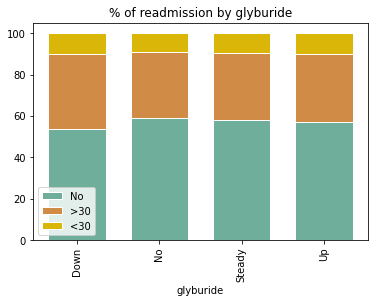

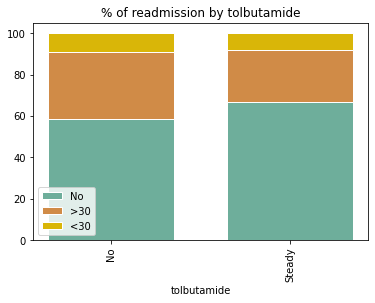

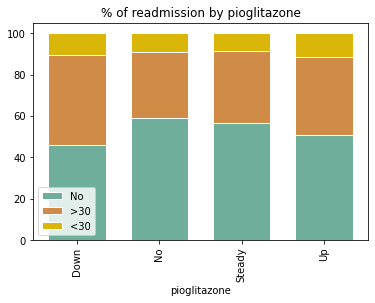

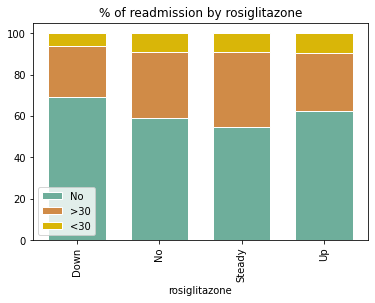

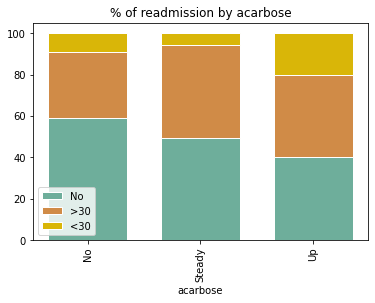

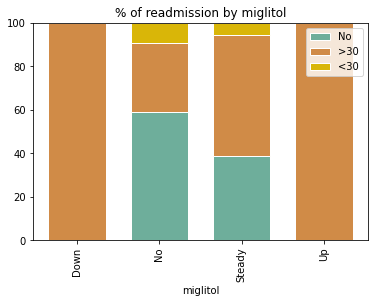

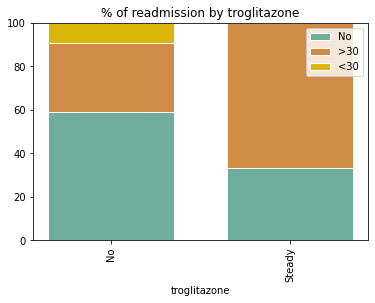

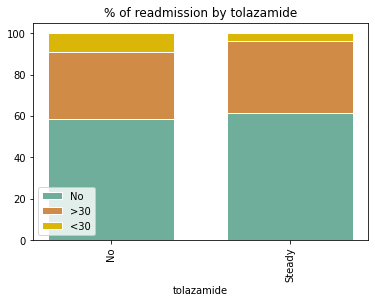

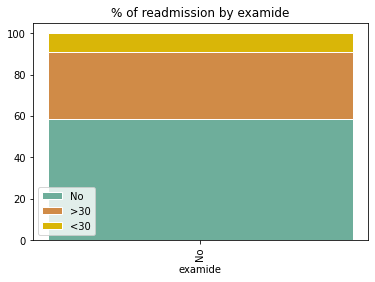

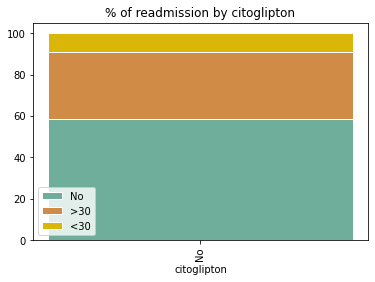

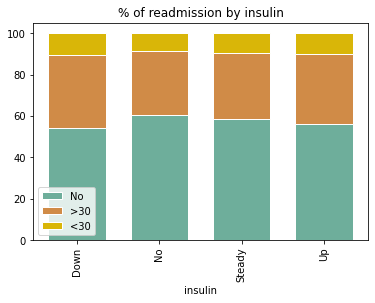

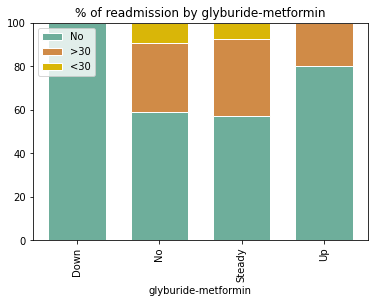

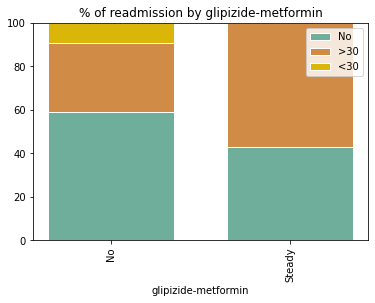

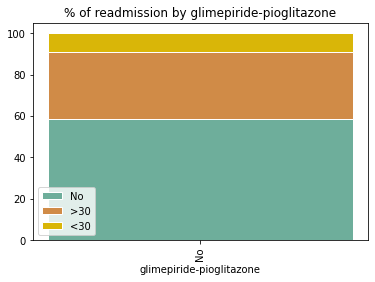

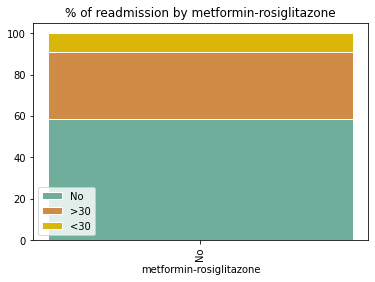

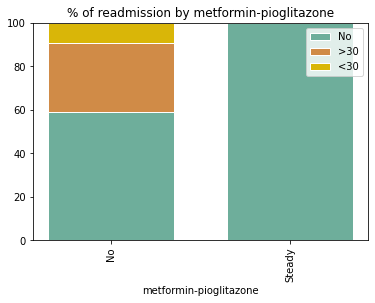

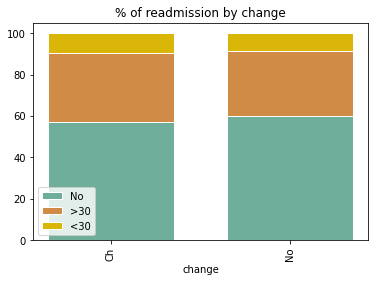

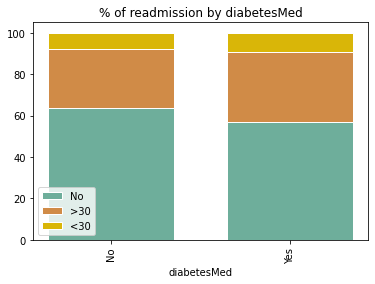

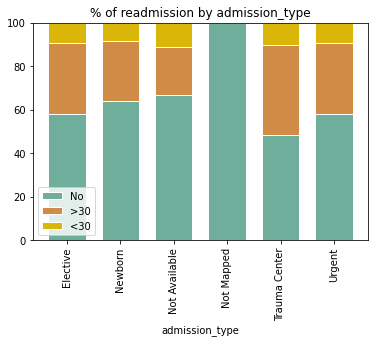

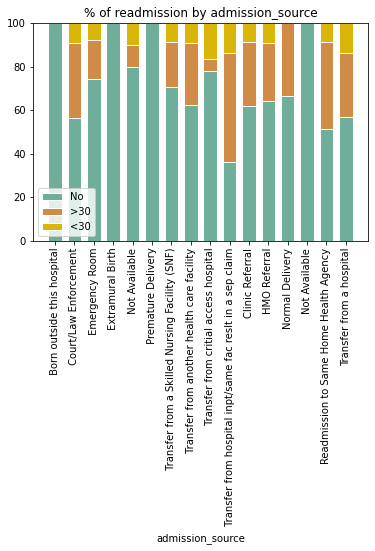

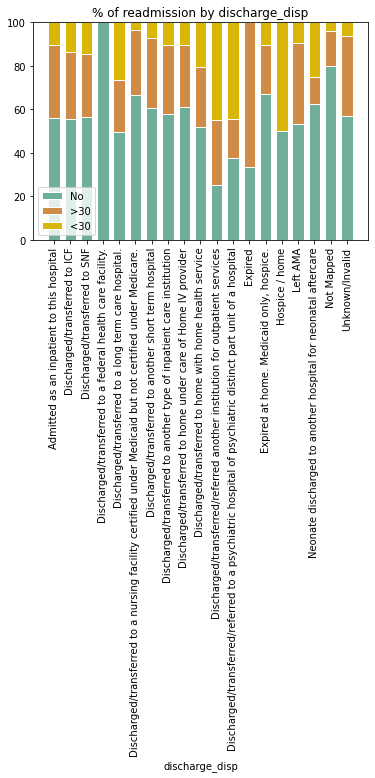

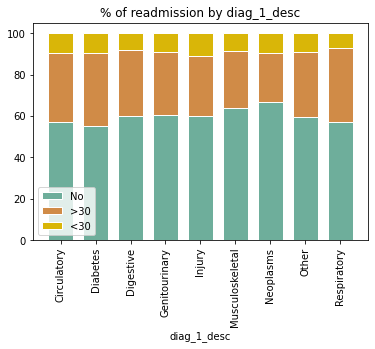

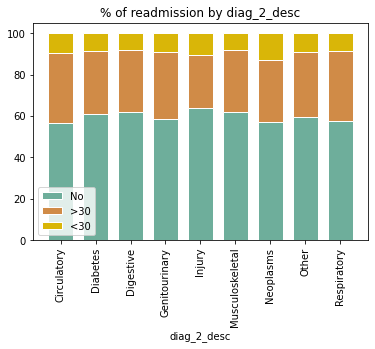

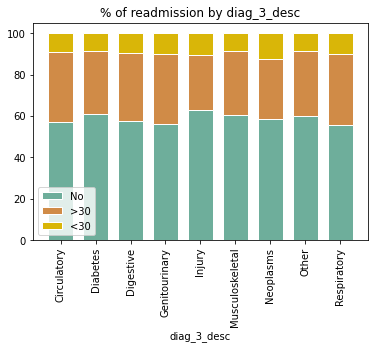

In [30]:
# Loop bar plots to show relationship of readmitted to other categorical variables
for i in categorical_feat:
    if i != 'readmitted':
        readm_cnt = ('readm_cnt_'+ i)
        read = ('read_' + i)
        pcts = ('pcts_' + i)
        unique_val_cnt = len(df[i].unique())  
        
        # Get counts of each value in i grouped by readmitted; show 0 values
        readm_cnt = df.groupby(['readmitted', i]).readmitted.count()
        levels = [readm_cnt.index.levels[0].values, readm_cnt.index.levels[1].values]
        new_index = pd.MultiIndex.from_product(levels, names=readm_cnt.index.names)
        readm_cnt = readm_cnt.reindex(new_index, fill_value=0)
        readm_cnt = readm_cnt.reset_index(name='counts')
        
        # Get percentages
        read = readm_cnt.groupby(['readmitted', i]).agg({'counts': 'sum'})
        read1 = readm_cnt.groupby([i]).agg({'counts': 'sum'})
        pcts = read.div(read1) * 100
        pcts = pcts.rename(columns = {'counts':'pcts'})
        pcts = pcts.reset_index()

        # Plot
        fig,ax = plt.subplots()

        # Values of each group
        bars1 = pcts.loc[pcts.readmitted=='NO','pcts'].tolist()
        bars2 = pcts.loc[pcts.readmitted=='>30','pcts'].tolist()
        bars3 = pcts.loc[pcts.readmitted=='<30','pcts'].tolist()

        bars = np.add(bars1, bars2).tolist()
        r = list(range(len(df[i].unique())))

        names = pcts[i]
        barWidth = 0.7

        plt.bar(r, bars1, color='#6EAE9B', edgecolor='white', width=barWidth)
        plt.bar(r, bars2, bottom=bars1, color='#D08B47', edgecolor='white', width=barWidth)
        plt.bar(r, bars3, bottom=bars, color='#D9B608', edgecolor='white', width=barWidth)

        plt.xticks(r, names, rotation='vertical')
        plt.xlabel(i)

        plt.title('% of readmission by ' + i)
        plt.legend(['No','>30','<30'])
        plt.show()

In [31]:
# Show percentages for each categorical features grouped by readmitted
for i in categorical_feat:
    if i != 'readmitted':
        readm_cnt = ('readm_cnt_'+ i)
        read = ('read_' + i)
        pcts = ('pcts_' + i)
        unique_val_cnt = len(df[i].unique())
        readm_cnt = df.groupby(['readmitted', i]).size().reset_index(name='counts')
        read = readm_cnt.groupby(['readmitted', i]).agg({'counts': 'sum'})
        read1 = readm_cnt.groupby([i]).agg({'counts': 'sum'})
        pcts = read.div(read1) * 100
        pcts = pcts.rename(columns = {'counts':'pcts'})
        print(pcts)

                                 pcts
readmitted race                      
<30        AfricanAmerican   8.751972
           Asian             8.817204
           Caucasian         9.288066
           Hispanic          7.965243
           Other             6.946984
>30        AfricanAmerican  30.748152
           Asian            22.580645
           Caucasian        32.843621
           Hispanic         27.226647
           Other            27.148080
NO         AfricanAmerican  60.499875
           Asian            68.602151
           Caucasian        57.868313
           Hispanic         64.808110
           Other            65.904936
                                  pcts
readmitted gender                     
<30        Female             9.225593
           Male               8.987137
>30        Female            32.811947
           Male              31.399421
NO         Female            57.962460
           Male              59.613442
           Unknown/Invalid  100.000000
   

# Data Preparation
1. One-hot encode categorical features
2. Scale numeric features
3. Join categorical, numeric, and target
4. Split into train and test sets


In [32]:
# Reset index
df.reset_index(inplace=True)
df.drop(columns='index')

,race,gender,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,admission_type,admission_source,discharge_disp,diag_1_desc,diag_2_desc,diag_3_desc
0,Caucasian,Female,[10-20),3,59,0,18,0,0,0,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30,Urgent,Court/Law Enforcement,Discharged/transferred to another short term h...,Other,Diabetes,Other
1,AfricanAmerican,Female,[20-30),2,11,5,13,2,0,1,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO,Urgent,Court/Law Enforcement,Discharged/transferred to another short term h...,Other,Diabetes,Other
2,Caucasian,Male,[30-40),2,44,1,16,0,0,0,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO,Urgent,Court/Law Enforcement,Discharged/transferred to another short term h...,Other,Diabetes,Circulatory
3,Caucasian,Male,[40-50),1,51,0,8,0,0,0,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO,Urgent,Court/Law Enforcement,Discharged/transferred to another short term h...,Neoplasms,Neoplasms,Diabetes
4,Caucasian,Male,[50-60),3,31,6,16,0,0,0,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,>30,Elective,HMO Referral,Discharged/transferred to another short term h...,Circulatory,Circulatory,Diabetes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63578,Caucasian,Female,[70-80),9,50,2,33,0,0,0,9,None,>7,No,No,No,No,No,No,No,Up,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,>30,Urgent,Court/Law Enforcement,Discharged/transferred to another short term h...,Digestive,Digestive,Diabetes
63579,Other,Female,[40-50),14,73,6,26,0,1,0,9,None,>8,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30,Urgent,Court/Law Enforcement,Discharged/transferred to another short term h...,Genitourinary,Genitourinary,Respiratory
63580,Other,Female,[60-70),2,46,6,17,1,1,1,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,>30,Urgent,Court/Law Enforcement,Discharged/transferred to another short term h...,Injury,Genitourinary,Circulatory
63581,Caucasian,Female,[80-90),5,76,1,22,0,1,0,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO,Urgent,Court/Law Enforcement,Discharged/transferred to another short term h...,Other,Other,Other


## 1. One-hot encode categorical features
 

In [33]:
df_categ = df[categorical_feat]
df_categ = df_categ.drop(columns='readmitted')
df_categ.head()

,race,gender,age,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,admission_type,admission_source,discharge_disp,diag_1_desc,diag_2_desc,diag_3_desc
0,Caucasian,Female,[10-20),None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,Urgent,Court/Law Enforcement,Discharged/transferred to another short term h...,Other,Diabetes,Other
1,AfricanAmerican,Female,[20-30),None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,Urgent,Court/Law Enforcement,Discharged/transferred to another short term h...,Other,Diabetes,Other
2,Caucasian,Male,[30-40),None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,Urgent,Court/Law Enforcement,Discharged/transferred to another short term h...,Other,Diabetes,Circulatory
3,Caucasian,Male,[40-50),None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,Urgent,Court/Law Enforcement,Discharged/transferred to another short term h...,Neoplasms,Neoplasms,Diabetes
4,Caucasian,Male,[50-60),None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,Elective,HMO Referral,Discharged/transferred to another short term h...,Circulatory,Circulatory,Diabetes


In [34]:
categorical_feat.remove('readmitted')
# One-hot encoding
one_hot_df = pd.get_dummies(df_categ, prefix=categorical_feat)
one_hot_df

,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Female,gender_Male,gender_Unknown/Invalid,age_[0-10),age_[10-20),age_[20-30),age_[30-40),age_[40-50),age_[50-60),age_[60-70),age_[70-80),age_[80-90),age_[90-100),max_glu_serum_>200,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>7,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,metformin_Down,metformin_No,metformin_Steady,metformin_Up,repaglinide_Down,repaglinide_No,repaglinide_Steady,repaglinide_Up,nateglinide_Down,nateglinide_No,nateglinide_Steady,nateglinide_Up,chlorpropamide_Down,chlorpropamide_No,...,discharge_disp_Discharged/transferred to another short term hospital,discharge_disp_Discharged/transferred to another type of inpatient care institution,discharge_disp_Discharged/transferred to home under care of Home IV provider,discharge_disp_Discharged/transferred to home with home health service,discharge_disp_Discharged/transferred/referred another institution for outpatient services,discharge_disp_Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital,discharge_disp_Expired,"discharge_disp_Expired at home. Medicaid only, hospice.",discharge_disp_Hospice / home,discharge_disp_Left AMA,discharge_disp_Neonate discharged to another hospital for neonatal aftercare,discharge_disp_Not Mapped,discharge_disp_Unknown/Invalid,diag_1_desc_Circulatory,diag_1_desc_Diabetes,diag_1_desc_Digestive,diag_1_desc_Genitourinary,diag_1_desc_Injury,diag_1_desc_Musculoskeletal,diag_1_desc_Neoplasms,diag_1_desc_Other,diag_1_desc_Respiratory,diag_2_desc_Circulatory,diag_2_desc_Diabetes,diag_2_desc_Digestive,diag_2_desc_Genitourinary,diag_2_desc_Injury,diag_2_desc_Musculoskeletal,diag_2_desc_Neoplasms,diag_2_desc_Other,diag_2_desc_Respiratory,diag_3_desc_Circulatory,diag_3_desc_Diabetes,diag_3_desc_Digestive,diag_3_desc_Genitourinary,diag_3_desc_Injury,diag_3_desc_Musculoskeletal,diag_3_desc_Neoplasms,diag_3_desc_Other,diag_3_desc_Respiratory
0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
4,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63578,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
63579,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
63580,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
63581,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0


## 2. Scale numeric features

In [35]:
df_numer = df[numerical_feat]
df_numer.head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
0,3,59,0,18,0,0,0,9
1,2,11,5,13,2,0,1,6
2,2,44,1,16,0,0,0,7
3,1,51,0,8,0,0,0,5
4,3,31,6,16,0,0,0,9


In [36]:
from sklearn.preprocessing import RobustScaler

#Scale numerical features
df_numer_scaled = pd.DataFrame(RobustScaler().fit_transform(df_numer[numerical_feat]), columns=numerical_feat)
df_numer_scaled

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
0,-0.25,0.56,-0.5,0.4,0.0,0.0,0.0,0.333333
1,-0.50,-1.36,2.0,-0.1,2.0,0.0,1.0,-0.666667
2,-0.50,-0.04,0.0,0.2,0.0,0.0,0.0,-0.333333
3,-0.75,0.24,-0.5,-0.6,0.0,0.0,0.0,-1.000000
4,-0.25,-0.56,2.5,0.2,0.0,0.0,0.0,0.333333
...,...,...,...,...,...,...,...,...
63578,1.25,0.20,0.5,1.9,0.0,0.0,0.0,0.333333
63579,2.50,1.12,2.5,1.2,0.0,1.0,0.0,0.333333
63580,-0.50,0.04,2.5,0.3,1.0,1.0,1.0,0.333333
63581,0.25,1.24,0.0,0.8,0.0,1.0,0.0,0.333333


## 3. Join categorical, numeric, and target

In [37]:
# Join one hot encoded features & numerical features
fin_df = one_hot_df.join(df_numer_scaled)
fin_df

,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Female,gender_Male,gender_Unknown/Invalid,age_[0-10),age_[10-20),age_[20-30),age_[30-40),age_[40-50),age_[50-60),age_[60-70),age_[70-80),age_[80-90),age_[90-100),max_glu_serum_>200,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>7,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,metformin_Down,metformin_No,metformin_Steady,metformin_Up,repaglinide_Down,repaglinide_No,repaglinide_Steady,repaglinide_Up,nateglinide_Down,nateglinide_No,nateglinide_Steady,nateglinide_Up,chlorpropamide_Down,chlorpropamide_No,...,discharge_disp_Hospice / home,discharge_disp_Left AMA,discharge_disp_Neonate discharged to another hospital for neonatal aftercare,discharge_disp_Not Mapped,discharge_disp_Unknown/Invalid,diag_1_desc_Circulatory,diag_1_desc_Diabetes,diag_1_desc_Digestive,diag_1_desc_Genitourinary,diag_1_desc_Injury,diag_1_desc_Musculoskeletal,diag_1_desc_Neoplasms,diag_1_desc_Other,diag_1_desc_Respiratory,diag_2_desc_Circulatory,diag_2_desc_Diabetes,diag_2_desc_Digestive,diag_2_desc_Genitourinary,diag_2_desc_Injury,diag_2_desc_Musculoskeletal,diag_2_desc_Neoplasms,diag_2_desc_Other,diag_2_desc_Respiratory,diag_3_desc_Circulatory,diag_3_desc_Diabetes,diag_3_desc_Digestive,diag_3_desc_Genitourinary,diag_3_desc_Injury,diag_3_desc_Musculoskeletal,diag_3_desc_Neoplasms,diag_3_desc_Other,diag_3_desc_Respiratory,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.25,0.56,-0.5,0.4,0.0,0.0,0.0,0.333333
1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.50,-1.36,2.0,-0.1,2.0,0.0,1.0,-0.666667
2,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,-0.50,-0.04,0.0,0.2,0.0,0.0,0.0,-0.333333
3,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,-0.75,0.24,-0.5,-0.6,0.0,0.0,0.0,-1.000000
4,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,-0.25,-0.56,2.5,0.2,0.0,0.0,0.0,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63578,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1.25,0.20,0.5,1.9,0.0,0.0,0.0,0.333333
63579,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2.50,1.12,2.5,1.2,0.0,1.0,0.0,0.333333
63580,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,-0.50,0.04,2.5,0.3,1.0,1.0,1.0,0.333333
63581,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0.25,1.24,0.0,0.8,0.0,1.0,0.0,0.333333


In [38]:
# Join target variable - readmitted
target = pd.DataFrame(df['readmitted'])
fin_df = fin_df.join(target)
fin_df

,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Female,gender_Male,gender_Unknown/Invalid,age_[0-10),age_[10-20),age_[20-30),age_[30-40),age_[40-50),age_[50-60),age_[60-70),age_[70-80),age_[80-90),age_[90-100),max_glu_serum_>200,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>7,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,metformin_Down,metformin_No,metformin_Steady,metformin_Up,repaglinide_Down,repaglinide_No,repaglinide_Steady,repaglinide_Up,nateglinide_Down,nateglinide_No,nateglinide_Steady,nateglinide_Up,chlorpropamide_Down,chlorpropamide_No,...,discharge_disp_Left AMA,discharge_disp_Neonate discharged to another hospital for neonatal aftercare,discharge_disp_Not Mapped,discharge_disp_Unknown/Invalid,diag_1_desc_Circulatory,diag_1_desc_Diabetes,diag_1_desc_Digestive,diag_1_desc_Genitourinary,diag_1_desc_Injury,diag_1_desc_Musculoskeletal,diag_1_desc_Neoplasms,diag_1_desc_Other,diag_1_desc_Respiratory,diag_2_desc_Circulatory,diag_2_desc_Diabetes,diag_2_desc_Digestive,diag_2_desc_Genitourinary,diag_2_desc_Injury,diag_2_desc_Musculoskeletal,diag_2_desc_Neoplasms,diag_2_desc_Other,diag_2_desc_Respiratory,diag_3_desc_Circulatory,diag_3_desc_Diabetes,diag_3_desc_Digestive,diag_3_desc_Genitourinary,diag_3_desc_Injury,diag_3_desc_Musculoskeletal,diag_3_desc_Neoplasms,diag_3_desc_Other,diag_3_desc_Respiratory,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,readmitted
0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.25,0.56,-0.5,0.4,0.0,0.0,0.0,0.333333,>30
1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.50,-1.36,2.0,-0.1,2.0,0.0,1.0,-0.666667,NO
2,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,-0.50,-0.04,0.0,0.2,0.0,0.0,0.0,-0.333333,NO
3,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,-0.75,0.24,-0.5,-0.6,0.0,0.0,0.0,-1.000000,NO
4,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,-0.25,-0.56,2.5,0.2,0.0,0.0,0.0,0.333333,>30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63578,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1.25,0.20,0.5,1.9,0.0,0.0,0.0,0.333333,>30
63579,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2.50,1.12,2.5,1.2,0.0,1.0,0.0,0.333333,>30
63580,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,-0.50,0.04,2.5,0.3,1.0,1.0,1.0,0.333333,>30
63581,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0.25,1.24,0.0,0.8,0.0,1.0,0.0,0.333333,NO


## 4. Split into train and test sets

In [39]:
from sklearn.model_selection import train_test_split

X = fin_df.drop(columns='readmitted')
y = fin_df['readmitted']

#Split into 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Modeling & Evaluation
1. Test on different groupings of target variable
   - Predicting 3 classes (<30, >30, No)
   - Predicting readmission (0: No, 1: <30 + >30)
   - Predicting early readmission (0: >30 + No, 1: <30)
2. For each grouping:
   - Resample training set
   - Fit classification models on training set & evaluate on test set
   - Get important features


In [40]:
# Resampling
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## Predicting 3 classes (<30, >30, No)

### Resample training set

In [41]:
#Resample & fit model on training set

#Specify how many samples we want for <30 class and >30 class after resampling
over_strategy = {'>30':21000, '<30':10000}
under_strategy = {'NO': 28000}

#Oversample minority classes (<30, >30)
oversample = SMOTENC(categorical_features=range(0,140), sampling_strategy=over_strategy)

#Undersample majority class (No)
undersample = RandomUnderSampler(sampling_strategy=under_strategy)

steps = [('o', oversample), ('u', undersample)]
resampling = Pipeline(steps=steps)

X_train_res, y_train_res = resampling.fit_resample(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


### Fit classification models on training set & evaluate on test set

Logistic regression

In [42]:
X_train_res = pd.DataFrame(X_train_res, columns=X_train.columns)
X_train_res

,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Female,gender_Male,gender_Unknown/Invalid,age_[0-10),age_[10-20),age_[20-30),age_[30-40),age_[40-50),age_[50-60),age_[60-70),age_[70-80),age_[80-90),age_[90-100),max_glu_serum_>200,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>7,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,metformin_Down,metformin_No,metformin_Steady,metformin_Up,repaglinide_Down,repaglinide_No,repaglinide_Steady,repaglinide_Up,nateglinide_Down,nateglinide_No,nateglinide_Steady,nateglinide_Up,chlorpropamide_Down,chlorpropamide_No,...,discharge_disp_Hospice / home,discharge_disp_Left AMA,discharge_disp_Neonate discharged to another hospital for neonatal aftercare,discharge_disp_Not Mapped,discharge_disp_Unknown/Invalid,diag_1_desc_Circulatory,diag_1_desc_Diabetes,diag_1_desc_Digestive,diag_1_desc_Genitourinary,diag_1_desc_Injury,diag_1_desc_Musculoskeletal,diag_1_desc_Neoplasms,diag_1_desc_Other,diag_1_desc_Respiratory,diag_2_desc_Circulatory,diag_2_desc_Diabetes,diag_2_desc_Digestive,diag_2_desc_Genitourinary,diag_2_desc_Injury,diag_2_desc_Musculoskeletal,diag_2_desc_Neoplasms,diag_2_desc_Other,diag_2_desc_Respiratory,diag_3_desc_Circulatory,diag_3_desc_Diabetes,diag_3_desc_Digestive,diag_3_desc_Genitourinary,diag_3_desc_Injury,diag_3_desc_Musculoskeletal,diag_3_desc_Neoplasms,diag_3_desc_Other,diag_3_desc_Respiratory,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.50,-0.12,-0.5,0.2,0.0,1.0,0.0,-0.666667
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.00,0.40,-0.5,0.4,0.0,0.0,0.0,0.333333
2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.50,-0.04,0.5,0.9,0.0,0.0,0.0,0.333333
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.75,0.72,0.0,1.2,0.0,0.0,0.0,-0.666667
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.50,0.24,-0.5,-0.9,0.0,0.0,0.0,-1.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58995,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.50,0.32,2.0,2.2,0.0,0.0,0.0,0.333333
58996,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0

In [43]:
#Fit logistic regression model
lr = LogisticRegression(max_iter=10000)
lr.fit(X_train_res, y_train_res)

#Get final evaluation metrics on test set for logistic regression
lr_train_score = lr.score(X_train_res, y_train_res)
lr_test_score = lr.score(X_test, y_test)
print("Logistic regression: ")
print("train mean accuracy: %f" %(lr_train_score))
print("test mean accuracy: %f" %(lr_test_score))

#Get confusion matrix and f1-score
y_pred = lr.predict(X_test)
f1 = f1_score(y_test, y_pred, average='weighted')
print(confusion_matrix(y_test, y_pred))
print("f1-score: %f" %(f1))

#Get feature names
features = np.array(X_train_res.columns)
#Sort coefficients in ascending order
sorted_coeff_index = lr.coef_[0].argsort()

#Get features with top 20 smallest and top 20 largest coefficients
print('Least important features (smallest coefs): \n{}\n'.format(features[sorted_coeff_index[:20]]))
print('Most important features (largest coefs): \n{}\n'.format(features[sorted_coeff_index[:-21:-1]]))

Logistic regression: 
train mean accuracy: 0.586898
test mean accuracy: 0.608791
[[  35  237  855]
 [  30  847 3109]
 [  38  706 6860]]
f1-score: 0.542147
Least important features (smallest coefs): 
['discharge_disp_Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.'
 'age_[0-10)' 'age_[10-20)' 'age_[90-100)' 'age_[50-60)'
 'discharge_disp_Unknown/Invalid' 'age_[40-50)' 'age_[20-30)'
 'age_[30-40)' 'age_[80-90)' 'age_[60-70)' 'age_[70-80)'
 'discharge_disp_Discharged/transferred to another short term hospital'
 'insulin_Up' 'discharge_disp_Left AMA' 'insulin_Down' 'insulin_Steady'
 'discharge_disp_Discharged/transferred to home under care of Home IV provider'
 'discharge_disp_Discharged/transferred to another type of inpatient care institution'
 'discharge_disp_Expired at home. Medicaid only, hospice.']

Most important features (largest coefs): 
['repaglinide_Up' 'nateglinide_No' 'chlorpropamide_No' 'tolbutamide_No'
 'acarbose_Up' 'g

Random forest

In [44]:
#Fit random classifier model
rf = RandomForestClassifier(n_estimators=50, max_depth=10, min_samples_leaf=5, min_samples_split=5)
rf.fit(X_train_res, y_train_res)


#Get evaluation metrics on test set for random forest
rf_train_score = rf.score(X_train_res, y_train_res)
rf_test_score = rf.score(X_test, y_test)
print("Random forest: ")
print("train mean accuracy: %f" %(rf_train_score))
print("test mean accuracy: %f" %(rf_test_score))

#Get confusion matrix and f1-score
y_pred = rf.predict(X_test)
f1 = f1_score(y_test, y_pred, average='weighted')
print(confusion_matrix(y_test, y_pred))
print("f1-score: %f" %(f1))

#Get feature names
features = np.array(X_train.columns)
#Sort coefficients in ascending order
sorted_coeff_index = rf.feature_importances_.argsort()

#Get features with top 20 smallest and top 20 largest coefficients
print('Least important features (smallest coefs): \n{}\n'.format(features[sorted_coeff_index[:20]]))
print('Most important features (largest coefs): \n{}\n'.format(features[sorted_coeff_index[:-21:-1]]))

Random forest: 
train mean accuracy: 0.562576
test mean accuracy: 0.607848
[[   1  257  869]
 [   1  816 3169]
 [   1  690 6913]]
f1-score: 0.534681
Least important features (smallest coefs): 
['glyburide-metformin_Up' 'citoglipton_No' 'examide_No' 'tolazamide_No'
 'troglitazone_Steady' 'troglitazone_No' 'miglitol_Up' 'miglitol_Steady'
 'glyburide-metformin_Down' 'miglitol_No' 'acarbose_Up'
 'rosiglitazone_Down' 'tolbutamide_Steady' 'tolbutamide_No'
 'acetohexamide_Steady' 'acetohexamide_No' 'glimepiride_Down'
 'miglitol_Down' 'chlorpropamide_Up' 'glipizide-metformin_No']

Most important features (largest coefs): 
['number_inpatient' 'number_diagnoses' 'time_in_hospital'
 'diabetesMed_Yes'
 'discharge_disp_Discharged/transferred to another short term hospital'
 'diabetesMed_No' 'num_medications' 'admission_type_Newborn'
 'number_outpatient' 'num_lab_procedures' 'num_procedures' 'age_[50-60)'
 'metformin_No' 'admission_source_ Court/Law Enforcement' 'race_Caucasian'
 'metformin_Steady' 

Neural networks

In [45]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import BatchNormalization

network1df = fin_df
network1df.readmitted = network1df.readmitted.replace('NO', 0)
network1df.readmitted = network1df.readmitted.replace('<30', 1)
network1df.readmitted = network1df.readmitted.replace('>30', 2)

X = network1df.drop(columns='readmitted')
y = network1df['readmitted']

#Split into 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


model = Sequential()


# 1st Dense Layer
model.add(Dense(512, input_dim=173, activation='relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())

# 2nd Dense Layer
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())

# 3rd Dense Layer
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())

# 4th Dense Layer
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())

# 5th Dense Layer
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())

# Output Layer
model.add(Dense(3))
model.add(Activation('softmax'))

model.summary()

# (4) Compile 
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# (5) Train
history = model.fit(X_train, y_train, batch_size=32, epochs=1000, verbose=1, validation_split=0.2, shuffle=True, callbacks=[keras.callbacks.EarlyStopping(patience=50)])

# (6) Evaluate Model
_, accuracy = model.evaluate(X_test, y_test)
print('Accuracy = ', (accuracy*100), '%')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               89088     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1

In [46]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

y_preds = model.predict(X_test)
y_preds = np.argmax(y_preds, axis=1)

print(metrics.classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.63      0.90      0.74      7526
           1       0.26      0.03      0.05      1163
           2       0.46      0.20      0.28      4028

    accuracy                           0.60     12717
   macro avg       0.45      0.38      0.36     12717
weighted avg       0.54      0.60      0.53     12717



## Predicting readmission (0: No, 1: <30 + >30)

In [80]:
fin_df['readmitted'].value_counts()

0    37345
2    20443
1     5795
Name: readmitted, dtype: int64

In [81]:
readmitted_df = fin_df.copy(deep=True)
replace_readmitted = lambda x: 1 if x!=0 else 0

readmitted_df['readmitted_or_not'] = readmitted_df.apply(lambda row: replace_readmitted(row['readmitted']), axis=1)
readmitted_df.drop(columns='readmitted', inplace=True)

readmitted_df['readmitted_or_not'].value_counts()

0    37345
1    26238
Name: readmitted_or_not, dtype: int64

In [82]:
X = readmitted_df.drop(columns='readmitted_or_not')
y = readmitted_df['readmitted_or_not']

#Split into 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Fit classification models on training set & evaluate on test set

Logistic regression

In [83]:
#Fit logistic regression model
lr = LogisticRegression(max_iter=10000)
lr.fit(X_train, y_train)

#Get final evaluation metrics on test set for logistic regression
lr_train_score = lr.score(X_train, y_train)
lr_test_score = lr.score(X_test, y_test)
print("Logistic regression: ")
print("train mean accuracy: %f" %(lr_train_score))
print("test mean accuracy: %f" %(lr_test_score))

#Get confusion matrix and f1-score
y_pred = lr.predict(X_test)
f1 = f1_score(y_test, y_pred, average='weighted')
print(confusion_matrix(y_test, y_pred))
print("f1-score: %f" %(f1))

#Get feature names
features = np.array(X_train.columns)
#Sort coefficients in ascending order
sorted_coeff_index = lr.coef_[0].argsort()

#Get features with top 20 smallest and top 20 largest coefficients
print('Least important features (smallest coefs): \n{}\n'.format(features[sorted_coeff_index[:20]]))
print('Most important features (largest coefs): \n{}\n'.format(features[sorted_coeff_index[:-21:-1]]))

Logistic regression: 
train mean accuracy: 0.627118
test mean accuracy: 0.629158
[[6429 1045]
 [3671 1572]]
f1-score: 0.594916
Least important features (smallest coefs): 
['admission_type_Not Mapped' 'discharge_disp_Not Mapped'
 'admission_source_ Transfer from critial access hospital' 'miglitol_No'
 'discharge_disp_Discharged/transferred to a federal health care facility.'
 'admission_source_ Born outside this hospital' 'glyburide-metformin_Down'
 'nateglinide_Up'
 'discharge_disp_Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.'
 'chlorpropamide_No' 'acarbose_No' 'discharge_disp_Unknown/Invalid'
 'age_[0-10)' 'admission_source_Normal Delivery'
 'admission_source_Not Available' 'race_Asian' 'glyburide-metformin_Up'
 'admission_source_ Not Available' 'chlorpropamide_Steady'
 'diag_1_desc_Neoplasms']

Most important features (largest coefs): 
['discharge_disp_Discharged/transferred/referred another institution for outpatient service

Random forest

In [84]:
#Fit random classifier model
rf = RandomForestClassifier(n_estimators=50, max_depth=10, min_samples_leaf=5, min_samples_split=5)
rf.fit(X_train, y_train)


#Get evaluation metrics on test set for random forest
rf_train_score = rf.score(X_train, y_train)
rf_test_score = rf.score(X_test, y_test)
print("Random forest: ")
print("train mean accuracy: %f" %(rf_train_score))
print("test mean accuracy: %f" %(rf_test_score))

#Get confusion matrix and f1-score
y_pred = rf.predict(X_test)
f1 = f1_score(y_test, y_pred, average='weighted')
print(confusion_matrix(y_test, y_pred))
print("f1-score: %f" %(f1))

#Get feature names
features = np.array(X_train.columns)
#Sort coefficients in ascending order
sorted_coeff_index = rf.feature_importances_.argsort()

#Get features with top 20 smallest and top 20 largest coefficients
print('Least important features (smallest coefs): \n{}\n'.format(features[sorted_coeff_index[:20]]))
print('Most important features (largest coefs): \n{}\n'.format(features[sorted_coeff_index[:-21:-1]]))

Random forest: 
train mean accuracy: 0.637007
test mean accuracy: 0.621609
[[6990  484]
 [4328  915]]
f1-score: 0.550814
Least important features (smallest coefs): 
['glyburide-metformin_Up' 'tolazamide_Steady' 'tolazamide_No'
 'troglitazone_Steady' 'troglitazone_No' 'miglitol_Up' 'miglitol_Steady'
 'miglitol_No' 'miglitol_Down' 'repaglinide_Up' 'nateglinide_Down'
 'acarbose_Up' 'rosiglitazone_Down' 'nateglinide_Up' 'chlorpropamide_Down'
 'chlorpropamide_Steady' 'chlorpropamide_Up' 'pioglitazone_Down'
 'tolbutamide_Steady' 'tolbutamide_No']

Most important features (largest coefs): 
['number_inpatient' 'number_diagnoses' 'num_medications'
 'num_lab_procedures' 'number_outpatient' 'number_emergency'
 'time_in_hospital' 'num_procedures' 'admission_type_Trauma Center'
 'admission_type_Newborn' 'diabetesMed_No' 'diabetesMed_Yes'
 'admission_source_ Court/Law Enforcement'
 'discharge_disp_Discharged/transferred to another short term hospital'
 'age_[70-80)'
 'admission_source_ Transfer from

Neural networks

In [85]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import BatchNormalization

model = Sequential()

# 1st Dense Layer
model.add(Dense(512, input_dim=173, activation='relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())

# 2nd Dense Layer
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())

# 3rd Dense Layer
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())

# 4th Dense Layer
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())

# 5th Dense Layer
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())

# Output Layer
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.summary()

# (4) Compile 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# (5) Train
history = model.fit(X_train, y_train, batch_size=32, epochs=1000, verbose=1, validation_split=0.2, shuffle=True, callbacks=[keras.callbacks.EarlyStopping(patience=50)])

# (6) Evaluate Model
_, accuracy = model.evaluate(X_test, y_test)
print('Accuracy = ', (accuracy*100), '%')

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 512)               89088     
_________________________________________________________________
dropout_20 (Dropout)         (None, 512)               0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 512)               2048      
_________________________________________________________________
dense_25 (Dense)             (None, 256)               131328    
_________________________________________________________________
activation_20 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 256)               0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 256)              

In [86]:
from sklearn import metrics
y_pred = model.predict(X_test)
print(metrics.classification_report(y_test, y_pred.round()))


              precision    recall  f1-score   support

           0       0.65      0.77      0.71      7474
           1       0.56      0.41      0.47      5243

    accuracy                           0.62     12717
   macro avg       0.60      0.59      0.59     12717
weighted avg       0.61      0.62      0.61     12717



## Predicting early readmission (<30 as 1,  >30 + No as 0)

In [58]:
fin_df['readmitted'].value_counts()

0    37345
2    20443
1     5795
Name: readmitted, dtype: int64

In [59]:
early_readmitted_df = fin_df.copy(deep=True)
replace_early_readmitted = lambda x: 1 if x==1 else 0

early_readmitted_df['early_readmitted_or_not'] = early_readmitted_df.apply(lambda row: replace_early_readmitted(row['readmitted']), axis=1)
early_readmitted_df['early_readmitted_or_not'].value_counts()

0    57788
1     5795
Name: early_readmitted_or_not, dtype: int64

In [60]:
early_readmitted_df.drop(columns='readmitted', inplace=True)
X = early_readmitted_df.drop(columns='early_readmitted_or_not')
y = early_readmitted_df['early_readmitted_or_not']

#Split into 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Resample training set

In [61]:
#Resample & fit model on training set

#Specify how many samples we want for <30 class and >30 class after resampling
over_strategy = {1:11590}
under_strategy = {0:29000}

#Oversample minority classes (<30, >30)
oversample = SMOTENC(categorical_features=range(0,140), sampling_strategy=over_strategy)

#Undersample majority class (No)
undersample = RandomUnderSampler(sampling_strategy=under_strategy)

steps = [('o', oversample), ('u', undersample)]
resampling = Pipeline(steps=steps)

X_train_res, y_train_res = resampling.fit_resample(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [62]:
X_train_res = pd.DataFrame(X_train_res, columns=X_train.columns)
X_train_res

,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Female,gender_Male,gender_Unknown/Invalid,age_[0-10),age_[10-20),age_[20-30),age_[30-40),age_[40-50),age_[50-60),age_[60-70),age_[70-80),age_[80-90),age_[90-100),max_glu_serum_>200,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>7,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,metformin_Down,metformin_No,metformin_Steady,metformin_Up,repaglinide_Down,repaglinide_No,repaglinide_Steady,repaglinide_Up,nateglinide_Down,nateglinide_No,nateglinide_Steady,nateglinide_Up,chlorpropamide_Down,chlorpropamide_No,...,discharge_disp_Hospice / home,discharge_disp_Left AMA,discharge_disp_Neonate discharged to another hospital for neonatal aftercare,discharge_disp_Not Mapped,discharge_disp_Unknown/Invalid,diag_1_desc_Circulatory,diag_1_desc_Diabetes,diag_1_desc_Digestive,diag_1_desc_Genitourinary,diag_1_desc_Injury,diag_1_desc_Musculoskeletal,diag_1_desc_Neoplasms,diag_1_desc_Other,diag_1_desc_Respiratory,diag_2_desc_Circulatory,diag_2_desc_Diabetes,diag_2_desc_Digestive,diag_2_desc_Genitourinary,diag_2_desc_Injury,diag_2_desc_Musculoskeletal,diag_2_desc_Neoplasms,diag_2_desc_Other,diag_2_desc_Respiratory,diag_3_desc_Circulatory,diag_3_desc_Diabetes,diag_3_desc_Digestive,diag_3_desc_Genitourinary,diag_3_desc_Injury,diag_3_desc_Musculoskeletal,diag_3_desc_Neoplasms,diag_3_desc_Other,diag_3_desc_Respiratory,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.750000,-0.840000,-0.500000,-0.700000,0.0,1.000000,0.000000,-0.666667
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.120000,-0.500000,-0.300000,0.0,0.000000,0.000000,0.000000
2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.250000,-0.720000,-0.500000,-0.300000,0.0,1.000000,0.000000,0.333333
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.750000,-1.600000,0.000000,-0.100000,0.0,0.000000,0.000000,0.333333
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.250000,-0.440000,-0.500000,-0.200000,0.0,0.000000,0.000000,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40585,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0

### Fit classification models on training set & evaluate on test set

Logistic regression

In [63]:
#Fit logistic regression model
lr = LogisticRegression(max_iter=10000)
lr.fit(X_train_res, y_train_res)

#Get final evaluation metrics on test set for logistic regression
lr_train_score = lr.score(X_train_res, y_train_res)
lr_test_score = lr.score(X_test, y_test)
print("Logistic regression: ")
print("train mean accuracy: %f" %(lr_train_score))
print("test mean accuracy: %f" %(lr_test_score))

#Get confusion matrix and f1-score
y_pred = lr.predict(X_test)
f1 = f1_score(y_test, y_pred, average='weighted')
print(confusion_matrix(y_test, y_pred))
print("f1-score: %f" %(f1))

#Get feature names
features = np.array(X_train_res.columns)
#Sort coefficients in ascending order
sorted_coeff_index = lr.coef_[0].argsort()

#Get features with top 20 smallest and top 20 largest coefficients
print('Least important features (smallest coefs): \n{}\n'.format(features[sorted_coeff_index[:20]]))
print('Most important features (largest coefs): \n{}\n'.format(features[sorted_coeff_index[:-21:-1]]))

Logistic regression: 
train mean accuracy: 0.867751
test mean accuracy: 0.908154
[[11521    82]
 [ 1086    28]]
f1-score: 0.872390
Least important features (smallest coefs): 
['age_[90-100)' 'age_[50-60)' 'age_[30-40)' 'age_[40-50)' 'age_[10-20)'
 'age_[20-30)' 'age_[80-90)' 'insulin_Up' 'age_[60-70)' 'insulin_Down'
 'age_[70-80)' 'age_[0-10)'
 'discharge_disp_Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.'
 'insulin_Steady' 'discharge_disp_Unknown/Invalid' 'insulin_No'
 'discharge_disp_Left AMA'
 'discharge_disp_Discharged/transferred to another short term hospital'
 'admission_type_Newborn' 'admission_type_Elective']

Most important features (largest coefs): 
['chlorpropamide_No' 'nateglinide_No' 'glyburide-metformin_No'
 'rosiglitazone_No' 'repaglinide_Up' 'tolbutamide_No' 'tolazamide_No'
 'diabetesMed_Yes' 'pioglitazone_No' 'diag_2_desc_Neoplasms'
 'diag_1_desc_Circulatory' 'diag_1_desc_Neoplasms' 'troglitazone_No'
 'glipizid

Random forest

In [64]:
#Fit random classifier model
rf = RandomForestClassifier(n_estimators=50, max_depth=10, min_samples_leaf=5, min_samples_split=5)
rf.fit(X_train_res, y_train_res)


#Get evaluation metrics on test set for random forest
rf_train_score = rf.score(X_train_res, y_train_res)
rf_test_score = rf.score(X_test, y_test)
print("Random forest: ")
print("train mean accuracy: %f" %(rf_train_score))
print("test mean accuracy: %f" %(rf_test_score))

#Get confusion matrix and f1-score
y_pred = rf.predict(X_test)
f1 = f1_score(y_test, y_pred, average='weighted')
print(confusion_matrix(y_test, y_pred))
print("f1-score: %f" %(f1))

#Get feature names
features = np.array(X_train.columns)
#Sort coefficients in ascending order
sorted_coeff_index = rf.feature_importances_.argsort()

#Get features with top 20 smallest and top 20 largest coefficients
print('Least important features (smallest coefs): \n{}\n'.format(features[sorted_coeff_index[:20]]))
print('Most important features (largest coefs): \n{}\n'.format(features[sorted_coeff_index[:-21:-1]]))

Random forest: 
train mean accuracy: 0.787903
test mean accuracy: 0.911221
[[11584    19]
 [ 1110     4]]
f1-score: 0.870621
Least important features (smallest coefs): 
['glyburide-metformin_Up' 'glyburide-metformin_Down' 'citoglipton_No'
 'examide_No' 'tolazamide_Steady' 'troglitazone_Steady' 'troglitazone_No'
 'miglitol_Up' 'miglitol_Steady' 'miglitol_No' 'miglitol_Down'
 'acarbose_Up' 'acarbose_Steady' 'acarbose_No' 'rosiglitazone_Down'
 'pioglitazone_Down' 'tolbutamide_Steady' 'tolbutamide_No'
 'glipizide-metformin_No' 'glipizide-metformin_Steady']

Most important features (largest coefs): 
['time_in_hospital' 'age_[50-60)' 'number_inpatient' 'diabetesMed_Yes'
 'diabetesMed_No' 'metformin_No'
 'discharge_disp_Discharged/transferred to another short term hospital'
 'number_diagnoses' 'insulin_Steady' 'race_Caucasian'
 'discharge_disp_Left AMA' 'metformin_Steady' 'num_medications'
 'admission_type_Elective' 'insulin_Up' 'glyburide_No' 'A1Cresult_None'
 'num_procedures' 'age_[60-70)' 

Neural nets

In [65]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import BatchNormalization

network1df = fin_df.copy(deep=True)
#network1df.readmitted = network1df.readmitted.replace('NO', 0)
#network1df.readmitted = network1df.readmitted.replace('<30', 1)
network1df.readmitted = network1df.readmitted.replace(2, 0)

X = network1df.drop(columns='readmitted')
y = network1df['readmitted']

#Split into 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


model = Sequential()

# 1st Dense Layer
model.add(Dense(512, input_dim=173, activation='relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())

# 2nd Dense Layer
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())

# 3rd Dense Layer
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())

# 4th Dense Layer
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())

# 5th Dense Layer
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())

# Output Layer
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.summary()

# (4) Compile 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# (5) Train
history = model.fit(X_train, y_train, batch_size=32, epochs=1000, verbose=1, validation_split=0.2, shuffle=True, callbacks=[keras.callbacks.EarlyStopping(patience=50)])

# (6) Evaluate Model
_, accuracy = model.evaluate(X_test, y_test)
print('Accuracy = ', (accuracy*100), '%')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 512)               89088     
_________________________________________________________________
dropout_15 (Dropout)         (None, 512)               0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 512)               2048      
_________________________________________________________________
dense_19 (Dense)             (None, 256)               131328    
_________________________________________________________________
activation_15 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 256)               0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 256)              

In [66]:
from sklearn import metrics
y_pred = model.predict(X_test)
print(metrics.classification_report(y_test, y_pred.round()))


              precision    recall  f1-score   support

           0       0.91      0.99      0.95     11552
           1       0.31      0.03      0.05      1165

    accuracy                           0.91     12717
   macro avg       0.61      0.51      0.50     12717
weighted avg       0.86      0.91      0.87     12717



In [67]:
!pip install shap
import shap
shap.initjs()

     |████████████████████████████████| 327kB 2.7MB/s 
  Created wheel for shap: filename=shap-0.36.0-cp36-cp36m-linux_x86_64.whl size=456460 sha256=952a04476d2274ad2dd495457cd35136a0045a9cc442d1640e1eba6c0ed187a3
  Stored in directory: /root/.cache/pip/wheels/fb/15/e1/8f61106790da27e0765aaa6e664550ca2c50ea339099e799f4
Successfully built shap


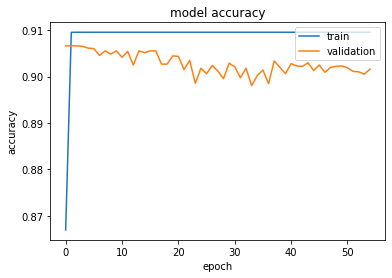

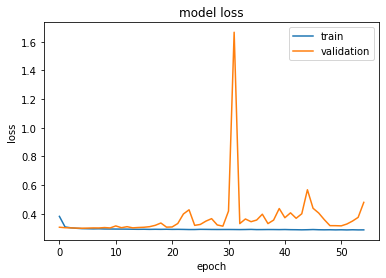

In [70]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

It's much more difficult to look at which features contribute to a neural network's decision compared to a model created using logistic regression, or random forest. To do so, we'll be using Shapely values to visualize the features that have an impact on the neural network's decision making. 

In [73]:
X_explain = X_test[:100] #Here we're only getting a small subset of X_test as large subsets take a very long time to run

In [74]:
explainer = shap.KernelExplainer(model.predict, X_explain)

In [75]:
shap_values = explainer.shap_values(X_explain)

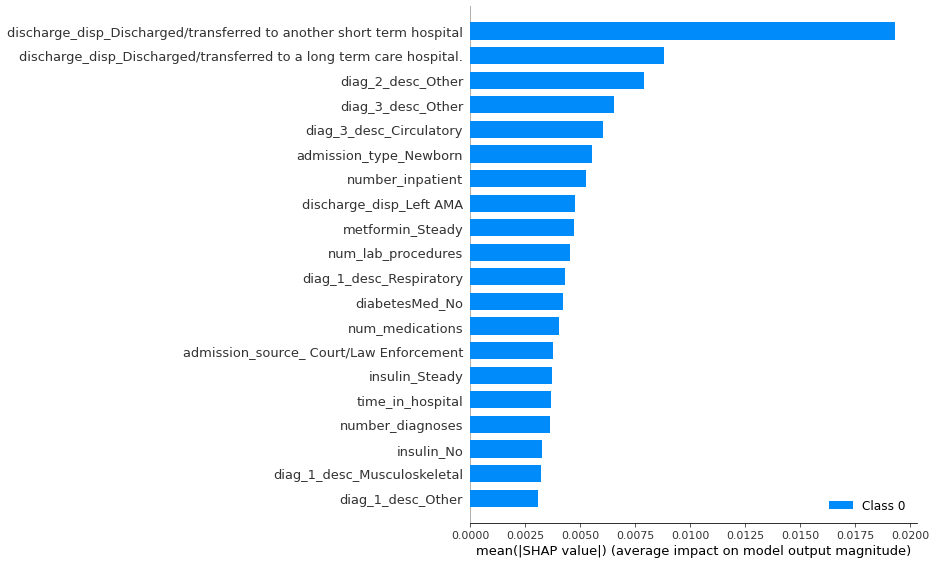

In [76]:
shap.summary_plot(shap_values, X_explain) #Here we are plotting the most significant features for the neural network

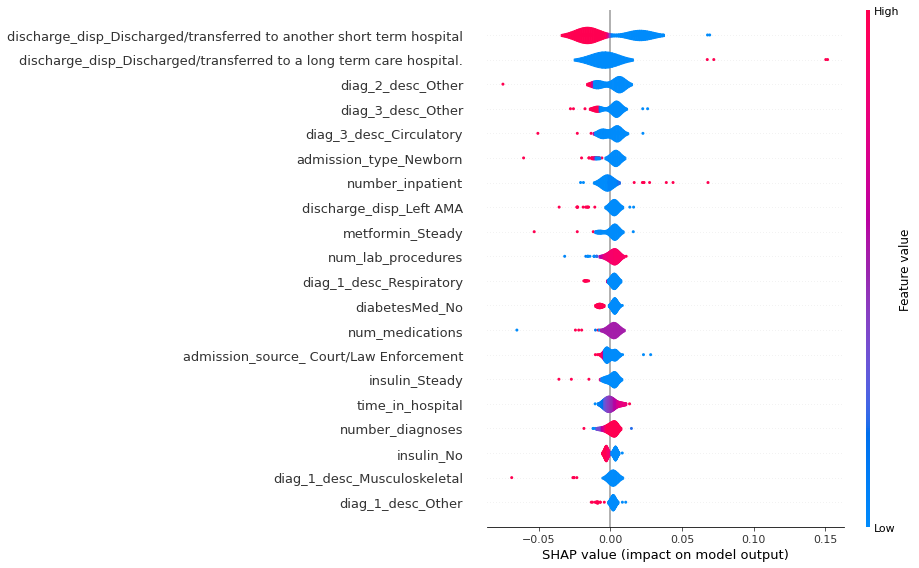

In [77]:
shap.summary_plot(shap_values[0], X_explain, plot_type="violin")

In [78]:
#Looking at an individual instance
#This visualization looks at an individual instance and shows how much each feature contributed to the neural network's decision
shap.initjs() 
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X_explain.iloc[0,:])

In [79]:
#Looking at all instances together
#This visualization is an interactive aggregate of all the instaces. 
#It takes each feature and stacks them on top of the other. Further exploring can be done by interacting with the visualization. 
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], X_explain)